In [1]:
import os
import torchvision
import torch
import pytorch_lightning as pl
import pandas as pd
from tqdm.auto import tqdm
import math
import librosa
import cv2
import torch.nn as nn
from metric import score
import albumentations as A
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torchaudio


/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Dataset and melspecs

In [2]:
# %load_ext autoreload

In [3]:
# %autoreload 2
from config import Config
    
config = Config()

print('fix seed')
pl.seed_everything(config.SEED, workers=True)

Seed set to 42


fix seed


42

In [4]:
config.VISUALIZE = True
config.OUTPUT_DIR = "/data/yaz/birdclef24/baselinev2/out"

In [15]:
df = pd.read_csv(config.DATA_ROOT + '/train_metadata.csv')
df["path"] = config.DATA_ROOT + "/train_audio/" + df["filename"]
df = df[df['rating'] <= 4.5].reset_index(drop=True)
df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

skf = StratifiedKFold(n_splits=config.N_FOLDS, random_state=config.SEED, shuffle=True)
df['fold'] = -1
for ifold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["primary_label"].values)):
    df.loc[val_idx, 'fold'] = ifold

sub = pd.read_csv(config.DATA_ROOT + "/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
label_list = target_columns
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}

/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


In [16]:
df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,path,fold
0,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,0.555556,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,/data/yaz/birdclef24/data/train_audio/asbfly/X...,1
1,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,0.555556,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,/data/yaz/birdclef24/data/train_audio/asbfly/X...,0
2,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,/data/yaz/birdclef24/data/train_audio/asbfly/X...,1
3,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,/data/yaz/birdclef24/data/train_audio/asbfly/X...,1
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://www.xeno-canto.org/209219,asbfly/XC209219.ogg,/data/yaz/birdclef24/data/train_audio/asbfly/X...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17905,zitcis1,[],[''],38.8471,20.6868,Cisticola juncidis,Zitting Cisticola,Danuta Peplowska-Marczak,Creative Commons Attribution-NonCommercial-Sha...,0.666667,https://xeno-canto.org/842049,zitcis1/XC842049.ogg,/data/yaz/birdclef24/data/train_audio/zitcis1/...,2
17906,zitcis1,[],[''],53.4047,7.0138,Cisticola juncidis,Zitting Cisticola,Alexander Schille,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://xeno-canto.org/845457,zitcis1/XC845457.ogg,/data/yaz/birdclef24/data/train_audio/zitcis1/...,0
17907,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://xeno-canto.org/845817,zitcis1/XC845817.ogg,/data/yaz/birdclef24/data/train_audio/zitcis1/...,1
17908,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,0.888889,https://xeno-canto.org/856176,zitcis1/XC856176.ogg,/data/yaz/birdclef24/data/train_audio/zitcis1/...,3


In [7]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 8 GPU(s)


## Dataset with melspecs

In [8]:
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=config.SR)
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav

In [9]:
transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(config.image_size, config.image_size),
    A.CoarseDropout(max_height=int(config.image_size * 0.375), max_width=int(config.image_size * 0.375), max_holes=1, p=0.7),
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(config.image_size, config.image_size),
    A.Normalize()
])

In [10]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=False, mode=None):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = config.secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**config.mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=config.top_db)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            if self.add_secondary_labels:
                for s in secondary_labels:
                    if s != "" and s in self.bird2id.keys():
                        target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target

    def prepare_spec(self, path):
        wav = read_wav(path)
        wav = crop_start_wav(wav, config.train_duration)
        mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        # mel_spectrogram = mel_spectrogram.permute(1, 2, 0).numpy()
        return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target, 'rating': rating}

## Model

In [11]:
import timm

In [12]:
class EffNet(nn.Module):
    def __init__(self, model_name=config.MODEL_TYPE, num_classes=None) -> None:
        super().__init__()

        self.model = timm.create_model(
            model_name, 
            pretrained=True, 
            in_chans=3, 
            num_classes=num_classes
        )
    
    def forward(self, x):
        # [B, W, H] -> [B, 1, W, H]
        # x = x.unsqueeze(1)
        x = self.model(x)

        return x

## Dataset

In [13]:
import gc
import matplotlib.pyplot as plt

In [14]:
dummy_dataset = BirdDataset(df)

sample_dict = dummy_dataset[0]
print(sample_dict['spec'].shape)


/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


(3, 128, 313)


In [15]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 6))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        sample = dummy_dataset[img_index[i]]
        img = sample['spec'][0]
        label = label_list[sample['target'].argmax()]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()

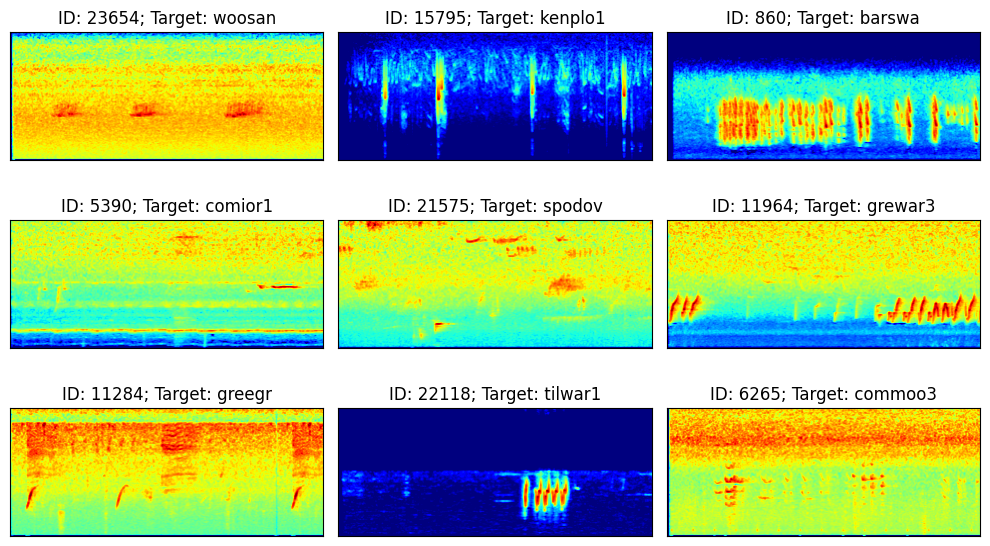

17827

In [16]:

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

## Training pipeline

In [17]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [18]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(num_classes=num_classes)
        
        # == loss function ==
        # self.loss_fn = nn.CrossEntropyLoss()
        self.loss_fn = FocalLossBCE() 
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # == define learning rate scheduler ==
        # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        #     model_optimizer,
        #     T_0=config.EPOCHS,
        #     T_mult=1,
        #     eta_min=1e-6,
        #     last_epoch=-1
        # )
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            model_optimizer,
            T_max=config.EPOCHS,
            eta_min=1e-6,
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    @staticmethod
    def mixup(data, targets, alpha):
        indices = torch.randperm(data.size(0))
        data2 = data[indices]
        targets2 = targets[indices]

        lam = torch.tensor([np.random.beta(alpha, alpha)], device=data.device)
        data = data * lam + data2 * (1 - lam)
        targets = targets * lam + targets2 * (1 - lam)

        return data, targets
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch["spec"], batch["target"]
        image, target = self.mixup(image, target, 0.5)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, prog_bar=True, on_step=True, on_epoch=True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch['spec'], batch['target']
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        # target_val = torch.nn.functional.one_hot(target_val, num_classes)
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, on_epoch=True)
        self.log("val_loss", val_loss, on_epoch=True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [19]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))
    
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

### Visualizer LR scheduler

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


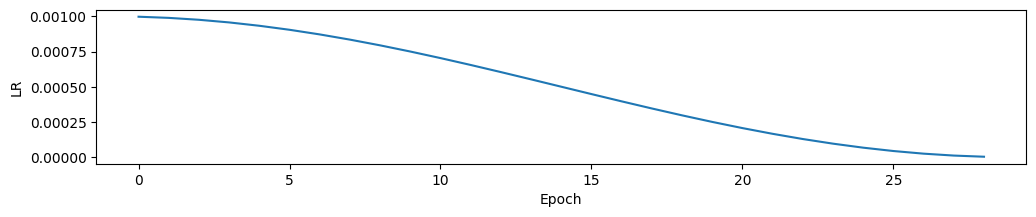

In [20]:
if config.VISUALIZE:
    dummy_model = EffNet()
    dummy_optimizer = torch.optim.AdamW(dummy_model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)

    dummy_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        dummy_optimizer,
        T_max=config.EPOCHS,
        # T_mult=1,
        eta_min=1e-6,
        # last_epoch=-1
    )

    plt.figure(figsize=(12, 2))
    lrs = []
    for epoch in range(1, config.EPOCHS):
        dummy_scheduler.step()
        lrs.append(dummy_optimizer.param_groups[0]["lr"])

    plt.plot(range(len(lrs)), lrs)
    plt.xlabel("Epoch")
    plt.ylabel("LR")

### Training funcs

In [54]:
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger

In [90]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df['fold'] != fold_id].copy()
    valid_df = total_df[total_df['fold'] == fold_id].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')
    
    train_ds = BirdDataset(train_df, mode='train', transform=transforms_train)
    val_ds = BirdDataset(valid_df, mode='valid', transform=transforms_val)
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=config.BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=config.OUTPUT_DIR,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    early_stop_callback = EarlyStopping(monitor="val_score", min_delta=0.00, patience=5, verbose=False, mode="max")

    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1), early_stop_callback]


    wandb_logger = WandbLogger(project="birdclef24", name=f"effnetb0_fold{fold_id}")
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=config.EPOCHS,
        # val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if config.MIXED_PRECISION else 32,
        logger=wandb_logger,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{config.OUTPUT_DIR}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

In [53]:
import argparse 

parser = argparse.ArgumentParser()
parser.add_argument("--fold", type=int, default=None)

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--fold FOLD]
ipykernel_launcher.py: error: argument --fold: invalid int value: '/home/yaz/.local/share/jupyter/runtime/kernel-v2-2767019tKxdRu7aFyHL.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [48]:
# training
torch.set_float32_matmul_precision('high')

train_df = df

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(config.N_FOLDS):

    if args.fold is not None and f != args.fold:
        continue
    
    # get validation index
    val_idx = list(train_df[train_df['fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)
    
    # # only training one fold
    # break


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{config.OUTPUT_DIR}/oof_pred.csv", index=False)

ValueError: invalid literal for int() with base 10: '/home/yaz/.local/share/jupyter/runtime/kernel-v2-2767019tKxdRu7aFyHL.json'